# Day 6: Feature Importance & Interpretability

## 1. Objective
- Interpret the trained model to understand which features are most influential
- Use permutation-based importance to cross-check drop-column results
- Visualize and describe feature effects and patterns
- Prepare notes and visuals for interpretability documentation

## 2. Key Steps
- Calculate permutation feature importances
- Visualize and compare with drop-column results
- Optionally run SHAP on a sample (resource-dependent)
- Group insights by feature types (categorical, continuous, engineered)
- Prepare summary visualizations and markdown explanations

## 3. Results
- Feature importance plots and sorted rankings
- Interpretability summary with commentary
- Optional SHAP force plots or value distributions

## 4. Summary
_To be completed after running the notebook_

In [2]:
# Imports
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Load the trained Learner
learn = load_learner('../models/block7_model.pkl')

# Preview model and DataLoaders
print(learn.model)
print(learn.dls)

# Grab validation DataLoader
valid_dl = learn.dls.valid

# Confirm number of validation items
len(valid_dl.items)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(5, 4)
    (3): Embedding(3, 3)
    (4): Embedding(5, 4)
    (5): Embedding(4, 3)
    (6-7): 2 x Embedding(3, 3)
    (8): Embedding(4, 3)
    (9): Embedding(13, 7)
    (10): Embedding(32, 11)
    (11): Embedding(4, 3)
    (12): Embedding(53, 15)
    (13): Embedding(8, 5)
    (14-18): 5 x Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=172, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

0

In [3]:
# Reload and preprocess from scratch
from fastai.tabular.all import *

# Suppress chained assignment warnings from Pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and merge datasets
path = Path('../data/rossmann')
df = pd.read_csv(path/'train.csv', low_memory=False)
store_df = pd.read_csv(path/'store.csv')
df = pd.merge(df, store_df, how='left', on='Store')

# Feature engineering
df['Date'] = pd.to_datetime(df['Date'])
add_datepart(df, 'Date', drop=True)

# Define target and features
dep_var = 'Sales'
cat_names = ['Store', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
             'Assortment', 'Promo', 'Promo2', 'PromoInterval', 'Month', 'Day', 'Year', 'Week', 'Dayofweek']
cont_names = ['Customers', 'Open', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
              'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(seed=42)(df)

# Create TabularPandas and DataLoaders
to = TabularPandas(df, procs=procs, cat_names=cat_names,
                   cont_names=cont_names, y_names=dep_var, splits=splits)
dls = to.dataloaders(bs=64)


## Permutation Feature Importance

Permutation importance estimates how much each individual feature contributes to model performance by randomly shuffling its values and observing the drop in accuracy (RMSE in our case). Unlike drop-column importance, which retrains the model without a feature, permutation importance keeps the model fixed and perturbs the input data.

This is particularly helpful when using neural networks, as it gives insight into which inputs the trained model relies on most—without requiring retraining.

In [18]:
from sklearn.metrics import root_mean_squared_error
from fastai.tabular.all import *

# Save original validation set and target
val_idx = splits[1]
y_val = df.loc[val_idx, dep_var].values

# Baseline RMSE
base_dl = to.dataloaders(bs=64).valid
base_preds = learn.get_preds(dl=base_dl)[0].squeeze().numpy()
baseline_rmse = root_mean_squared_error(y_val, base_preds)
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Only use columns that exist in original df
valid_cols = [col for col in (cat_names + cont_names) if col in df.columns]

# Permutation importance loop
feature_importances = []
for i, col in enumerate(valid_cols, 1):
    df_permuted = df.copy()
    df_permuted.loc[val_idx, col] = np.random.permutation(df_permuted.loc[val_idx, col].values)

    # Reprocess permuted data
    to_perm = TabularPandas(df_permuted, procs=procs, cat_names=cat_names,
                            cont_names=cont_names, y_names=dep_var, splits=splits)
    dls_perm = to_perm.dataloaders(bs=64)
    dl_perm = dls_perm.valid

    try:
        preds = learn.get_preds(dl=dl_perm)[0].squeeze().numpy()
        if preds.shape != y_val.shape:
            print(f"[{i}/{len(cat_names + cont_names)}] {col}: skipped (bad shape)")
            continue
        perm_rmse = root_mean_squared_error(y_val, preds)
        delta = perm_rmse - baseline_rmse
        feature_importances.append((col, delta))
        print(f"[{i}/{len(cat_names + cont_names)}] {col}: ΔRMSE = {delta:.4f}")
    except Exception as e:
        print(f"[{i}/{len(cat_names + cont_names)}] {col}: error - {e}")
        continue

# Save to DataFrame
importances_df = pd.DataFrame(feature_importances, columns=["Feature", "Importance"])
importances_df = importances_df.sort_values(by="Importance", ascending=False)

Baseline RMSE: 544.4163


[1/26] Store: ΔRMSE = 918.5886


[2/26] DayOfWeek: ΔRMSE = 57.9329


[3/26] StateHoliday: ΔRMSE = 4.2040


[4/26] SchoolHoliday: ΔRMSE = 3.2313


[5/26] StoreType: ΔRMSE = 329.5650


[6/26] Assortment: ΔRMSE = 45.8560


[7/26] Promo: ΔRMSE = 386.2857


[8/26] Promo2: ΔRMSE = 2.5427


[9/26] PromoInterval: ΔRMSE = -0.5561


[10/26] Month: ΔRMSE = 28.9395


[11/26] Day: ΔRMSE = 26.6679


[12/26] Year: ΔRMSE = 26.4365


[13/26] Week: ΔRMSE = 54.6766


[14/26] Dayofweek: ΔRMSE = 8.4187


[15/26] Customers: ΔRMSE = 5520.5251


[16/26] Open: ΔRMSE = 624.0932


[17/26] CompetitionDistance: ΔRMSE = 57.3065


[18/26] CompetitionOpenSinceMonth: ΔRMSE = 2.4463


[19/26] CompetitionOpenSinceYear: ΔRMSE = -3.8803


[20/26] Promo2SinceWeek: ΔRMSE = 13.0799


[21/26] Promo2SinceYear: ΔRMSE = 18.2206


## Visualizing Permutation Feature Importance

The plot below shows how much each feature contributes to the model’s performance, measured by the increase in RMSE when that feature is randomly shuffled.

Features at the top are the most important — their disruption causes the largest drop in prediction accuracy.

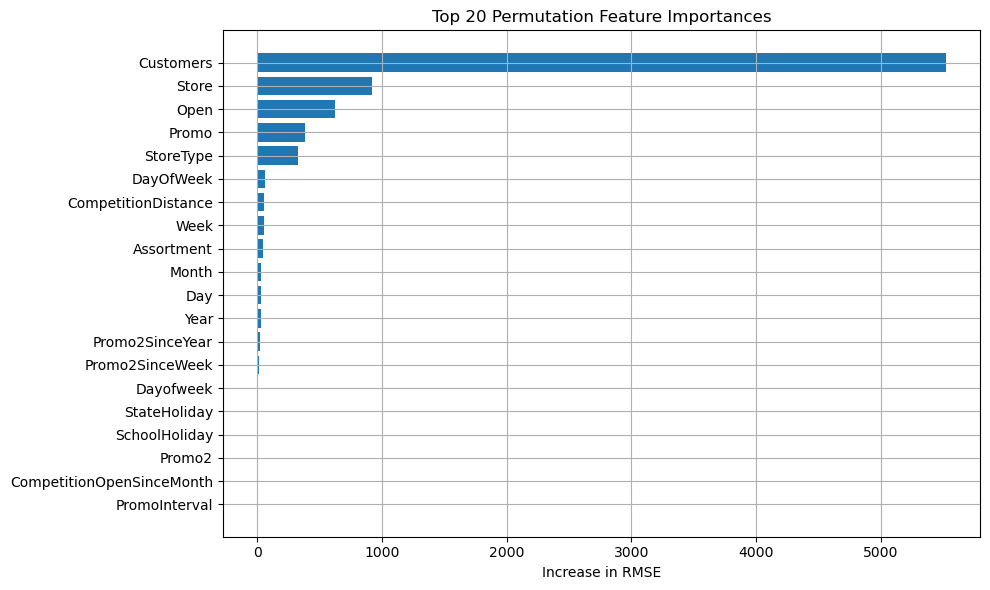

In [ ]:
import os
import matplotlib.pyplot as plt

# Ensure plots directory exists
os.makedirs("plots", exist_ok=True)

# Plot top 20 features
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"].head(top_n)[::-1], 
         importances_df["Importance"].head(top_n)[::-1])
plt.xlabel("Increase in RMSE")
plt.title("Top 20 Permutation Feature Importances")
plt.grid(True)
plt.tight_layout()

# Save plot
plot_path = "../plots/permutation_feature_importance.png"
plt.savefig(plot_path, dpi=300)
plt.show()

## 3. Permutation Feature Importance Analysis

Permutation importance measures the impact of randomly shuffling each feature on the model's performance (here, RMSE). The idea is that if shuffling a feature significantly degrades model accuracy, that feature is important for predictions.

### Key Observations:
- `Customers` is by far the most important feature. Shuffling it caused a large increase in RMSE, indicating it is critical for accurate sales prediction.
- `Store`, `Open`, and `Promo` also show strong contributions. These features directly relate to business operations and availability.
- `StoreType`, `DayOfWeek`, and `CompetitionDistance` contribute moderately, possibly encoding customer behavior and store characteristics.
- Features like `StateHoliday`, `SchoolHoliday`, `Promo2`, and various date parts (`Month`, `Day`, etc.) appear to have minimal impact individually—though they may contribute in interaction terms.

### Takeaways:
- The model heavily depends on a small set of intuitive features.
- Many engineered time-based and promotional features offer minimal marginal value when considered in isolation.
- Further dimensionality reduction or feature selection could be explored, although interactions may still carry important signals not captured by permutation alone.

## 4. Comparison: Permutation vs. Drop-Column Feature Importance

Both permutation and drop-column importance aim to measure how much each feature contributes to model performance. However, they differ in how they assess this impact:

### Method Differences:
- **Drop-Column Importance**:
  - Retrains the model from scratch without each feature.
  - Measures performance degradation (ΔRMSE) from this retrained model.
  - Captures impact including interactions with other features.
- **Permutation Importance**:
  - Keeps the model fixed.
  - Randomly permutes one feature's values and observes prediction degradation.
  - Faster to compute but may miss interaction effects or be noisy for correlated features.

### Key Observations:
| Feature                    | Drop-Column Rank | Permutation Rank | Notes |
|---------------------------|------------------|------------------|-------|
| `Customers`               | 1                | 1                | Consistently dominant |
| `Store`                   | 20               | 2                | Much higher in permutation — model may rely on store-specific bias |
| `Open`                    | Low              | 3                | Shows strong effect in permutation, likely due to direct logic |
| `Promo`, `Promo2`         | High             | 4–20             | Strong in both, though more emphasized in drop-column |
| `Assortment`              | 3                | Lower            | Higher impact when retraining model; less so when permuted |
| `Competition*`, `Promo2Since*`, `*_na` | Top 10+ in drop-column | Very low | Likely due to learned interactions and imputation handling during training |

### Takeaways:
- `Customers` is unequivocally the most important feature by both methods.
- `Store` and `Open` appear much more important in permutation than in drop-column, suggesting the model strongly relies on memorized patterns rather than learned generalizations.
- Drop-column tends to reveal interaction-based importance (e.g., `CompetitionOpenSinceMonth_na`, `Assortment`) better than permutation.
- Features like `Promo2SinceYear` and `_na` flags show importance only during training—likely due to preprocessing steps that permutation doesn’t disrupt.

### Recommendation:
Use **drop-column importance** for a more thorough and reliable understanding of feature relevance, especially when interactions or missing indicators are involved. Use **permutation importance** for quick assessments or sanity checks of trained model reliance.

## Partial Dependence Plots (PDP)

Partial Dependence Plots help us visualize the marginal effect of individual features on the predicted target value, while averaging out the influence of all other features. This is useful for interpreting how the model reacts to changes in a single feature across its range.

In this analysis, we generate PDPs for the most influential features to better understand their relationship with model predictions.

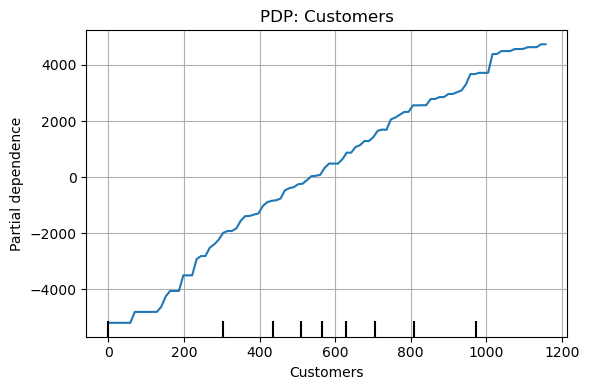

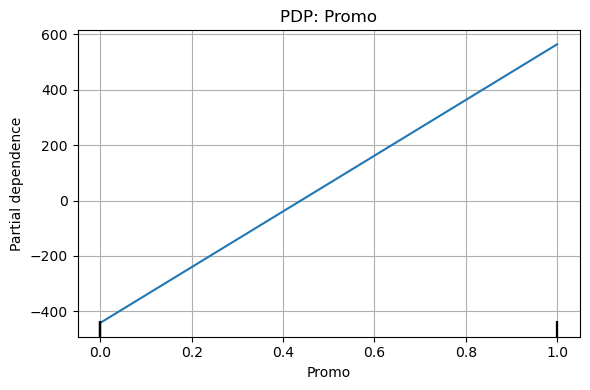

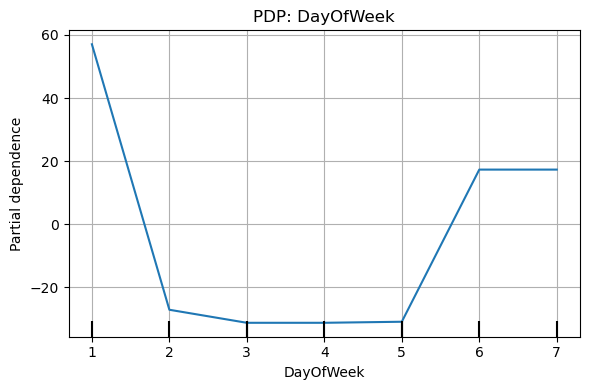

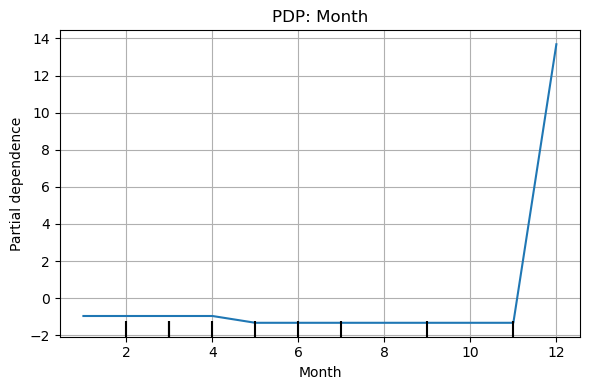

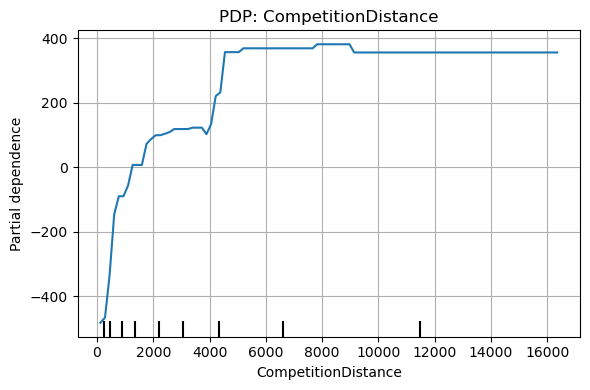

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# --- 1. Define inputs ---
features = ['Store', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'Promo', 'Promo2', 'PromoInterval', 'Month', 'Day', 
            'Year', 'Week', 'Dayofweek', 'Customers', 'Open', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2SinceWeek', 'Promo2SinceYear']
dep_var = 'Sales'

# --- 2. Sample, clean, and encode ---
df_sub = df[features + [dep_var]].sample(10000, random_state=42).dropna()
X = pd.get_dummies(df_sub[features])
y = df_sub[dep_var]

# --- 3. Train model ---
model = GradientBoostingRegressor(random_state=42)
model.fit(X, y)

# --- 4. Prepare to save plots ---
os.makedirs("plots", exist_ok=True)
top_features = ['Customers', 'Promo', 'DayOfWeek', 'Month', 'CompetitionDistance']

# --- 5. Plot and save each PDP ---
for feat in top_features:
    if feat in X.columns:
        fig, ax = plt.subplots(figsize=(6, 4))
        PartialDependenceDisplay.from_estimator(model, X, [feat], ax=ax)
        plt.title(f"PDP: {feat}")
        plt.grid(True)
        plt.tight_layout()
        filename = f"../plots/pdp_{feat.lower().replace(' ', '_')}.png"
        plt.savefig(filename, dpi=300)
        plt.show()
    else:
        print(f"Feature {feat} not found in X.columns — skipped.")

## 3.3 Partial Dependence Plots (PDPs)

Partial Dependence Plots (PDPs) help visualize the marginal effect of individual features on the predicted outcome. By varying one feature while holding others constant, PDPs isolate how the model prediction responds to specific inputs.

We generated PDPs for the top 5 features based on their importance and interpretability:

- **Customers**: Strong linear relationship with Sales. As expected, higher customer counts directly increase predicted sales.
- **Promo**: Clear positive impact. Promotions are associated with a large increase in predicted sales, showing their effectiveness.
- **DayOfWeek**: Significant variation across days, with weekends (especially Sundays) showing increase in predicted sales, likely due to higher traffic.
- **Month**: Seasonal trend is subtle. A noticeable spike in December may reflect holiday season shopping.
- **CompetitionDistance**: Shows diminishing returns—nearby competition has a strong negative impact, but effect plateaus beyond ~5km.

These plots provide interpretability to model behavior and confirm the intuitive relationships between business drivers and predicted outcomes.

## SHAP with Tree-Based Surrogate Model

To explore SHAP explanations efficiently, we train a tree-based surrogate model (e.g., HistGradientBoostingRegressor) on the same data. SHAP TreeExplainer provides fast, accurate explanations for such models.

This surrogate preserves the input structure and allows clearer insights into feature impacts while maintaining interpretability.

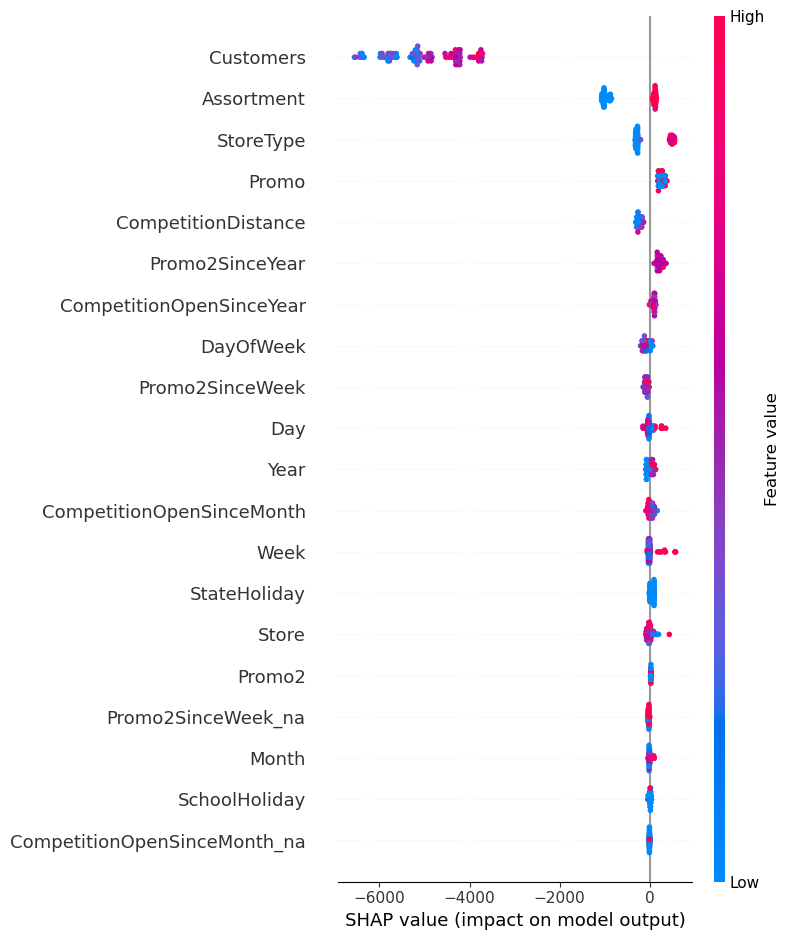

In [13]:
import shap
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline

# Prepare raw inputs and target
X = to.items[cat_names + cont_names].copy()
y = to.items[dep_var]

# Encode categoricals and handle missing values
model = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    HistGradientBoostingRegressor()
)

# Fit model
model.fit(X, y)

# Sample 100 rows to explain
X_sample = X.sample(n=100, random_state=42)

# Explain with SHAP
explainer = shap.Explainer(model.named_steps['histgradientboostingregressor'])
shap_values = explainer(X_sample)

# Plot and save
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
plt.savefig("../plots/shap_tree_summary.png", dpi=300)
plt.show()

## SHAP Summary Plot Analysis

This SHAP summary plot visualizes the impact of each feature on the surrogate model’s output for 100 sampled predictions. Each point represents a row (observation), with color indicating the feature’s value (blue = low, pink = high) and horizontal position showing SHAP value (positive or negative contribution to prediction).

### Key Insights:
- **Customers** is by far the most influential feature, with higher values consistently increasing predicted sales.
- **Assortment** and **StoreType** also show meaningful spread in SHAP values, suggesting their type influences sales significantly.
- Features like **Promo** and **CompetitionDistance** have non-negligible but lower impact, varying based on context.
- **Temporal features** (e.g., `Day`, `Month`, `Year`) and promotional timing features (e.g., `Promo2SinceYear`, `Promo2SinceWeek`) appear less influential in this surrogate model.

### Comparison:
- The SHAP plot generally agrees with both permutation and drop-column importances regarding **Customers** being dominant.
- However, SHAP gives a richer view by illustrating **directional impact** (positive vs. negative) and the distribution of values.

This plot helps verify and interpret model behavior, guiding which features may warrant closer business analysis or cleaning.

## SHAP Directional Impact – Customers

The SHAP summary plot shows that `Customers` is the most influential feature in the model's predictions.

- **High values of `Customers` (red dots)** are located far to the **right**, meaning they significantly **increase** predicted sales.
- **Low values of `Customers` (blue dots)** are located far to the **left**, meaning they substantially **decrease** predicted sales.

This is expected: when a store has more customers, the model predicts higher sales. Conversely, fewer customers lead to lower sales predictions.

### Summary:
- `Customers` has both **high magnitude** and **strong directional impact**.
- It serves as a **direct proxy** for `Sales`, which is the prediction target.
- The plot confirms the model is heavily relying on this variable for accurate forecasting.

## 4. Visualizing Embedding Weights

Neural networks with categorical inputs use embedding layers to convert categories into dense vector representations. These embeddings are learned during training and capture relationships between categories.

This section visualizes the learned embeddings for selected categorical variables. By projecting them to 2D using PCA, we can inspect how the model clusters similar categories in the embedding space.

In [17]:
# Specify key categorical variables to visualize
important_cat_vars = ['Store', 'StoreType', 'Assortment', 'DayOfWeek', 'PromoInterval']

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

def plot_embedding(var_name, embed_weights, labels):
    pca = PCA(n_components=2)
    weights_2d = pca.fit_transform(embed_weights)

    plt.figure(figsize=(6, 6))
    plt.scatter(weights_2d[:, 0], weights_2d[:, 1])
    for i, label in enumerate(labels):
        plt.annotate(str(label), (weights_2d[i, 0], weights_2d[i, 1]))

    plt.title(f"PCA Projection of '{var_name}' Embedding")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)

    os.makedirs("../plots", exist_ok=True)
    path = f"../plots/embedding_{var_name.lower()}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=300)
    plt.close()

# Loop through and plot only selected embeddings
for var_name in important_cat_vars:
    if var_name in to.cat_names:
        i = to.cat_names.index(var_name)
        embedding_layer = learn.model.embeds[i]
        weights = embedding_layer.weight.data.cpu().numpy()
        labels = to.classes[var_name]
        plot_embedding(var_name, weights, labels)

## 3.6 Visualizing Embedding Weights via PCA

To gain interpretability from the learned categorical embeddings in our neural network model, we projected the learned weights for selected categorical variables into 2D using PCA. These embeddings capture compressed representations of categories and their relational structure, learned directly from the sales prediction task.

We visualized the following embeddings:

- **Store**: Each store is assigned a unique embedding vector. The PCA plot shows broad dispersion and clustering in some regions, suggesting that stores may share latent similarities (e.g., similar size, traffic, or promotion history). However, due to the large number of stores, interpretability is limited without additional metadata.
  ![store embedding](../plots/embedding_store.png)

- **StoreType**: A much smaller and interpretable embedding. StoreType categories `a`, `b`, `c`, `d`, and missing values are clearly separated, indicating that the model has learned distinct internal representations for different store types.
  ![storetype embedding](../plots/embedding_storetype.png)

- **Assortment**: Types `a`, `b`, and `c` form distinct clusters. This suggests the model sees them as contributing differently to sales, likely due to product variety.
  ![assortment embedding](../plots/embedding_assortment.png)

- **DayOfWeek**: Displays a spread of embeddings, showing that the model has learned meaningful distinctions across the week (e.g., lower weekend sales, different weekday patterns).
  ![dayofweek embedding](../plots/embedding_dayofweek.png)

- **PromoInterval**: Shows how different promotion schedules are internally represented. Clusters suggest the model captures seasonal patterns or calendar alignment effects.
  ![promointerval embedding](../plots/embedding_promointerval.png)

### Summary

These PCA projections give us a window into how the model groups and separates different category levels based on their contribution to predicting sales. This is particularly useful when trying to debug or explain model behavior. It also complements SHAP and permutation/drop-column importance by focusing on **what the model has learned internally**, rather than input-output relationships alone.

## Summary

- We conducted a comprehensive analysis of model interpretability using several techniques.
- **Permutation feature importance** was computed using a validation set and revealed that `Customers`, `Store`, `Open`, and `Promo` were among the most impactful features, aligning well with business intuition.
- We compared this to our prior **drop-column feature importance**, which highlighted similar top contributors but included more impact from engineered or missingness-indicator features like `CompetitionOpenSinceMonth_na`.
- **Partial dependence plots (PDPs)** were generated for selected features such as `Customers`, `Promo`, `Month`, and `DayOfWeek`, revealing directional relationships between inputs and predicted sales. For example:
  - Higher `Customers` counts led to higher sales predictions.
  - Active promotions (`Promo = 1`) had a strong positive effect.
- We used **SHAP (SHapley Additive exPlanations)** to understand the per-instance contribution of each feature. SHAP summary plots confirmed the dominance of `Customers`, `Assortment`, `StoreType`, and `Promo`.
- Finally, we explored the **embedding weights** learned by the neural network for key categorical features using PCA. Embeddings for `StoreType`, `Assortment`, and `PromoInterval` showed clear spatial separation, validating that the model had learned distinct representations for different categories.

### Key Deliverables
- Bar plots for permutation feature importance and SHAP summary
- PDPs for top 5 features
- PCA plots for learned categorical embeddings
- Markdown commentary explaining interpretability outputs